In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import pygame
import random

import pickle

import gym
from gym import spaces
from gym.utils import seeding


pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Multi Agent Reinforcement Learning - Lumberjack


In [106]:
!pip install update pip
!pip install 'pip<=23.0.1'
!pip install 'setuptools<=66'
!pip install 'wheel<=0.38.4'


In [107]:
%pip install ma-gym

Note: you may need to restart the kernel to use updated packages.


In [108]:
from ma_gym.envs.lumberjacks.lumberjacks import Lumberjacks

In [124]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.actor = nn.Linear(64, action_dim)
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        action_probs = torch.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)
        return action_probs, state_value

    def act(self, state):
        action_probs, _ = self.forward(state)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        # print("Action: ",action)
        return action.item(), action_dist.log_prob(action)


def collect_trajectories(env, model_p1, model_p2, num_steps):
    obs = env.reset()
    states_p1, states_p2, actions_p1, actions_p2 = [], [], [], []
    rewards_p1, rewards_p2 = [], []
    dones, log_probs_p1, log_probs_p2 = [], [], []
    values_p1, values_p2 = [], []

    for _ in range(num_steps):
        # Separate observation for each agent
        state_p1 = torch.tensor(obs[0], dtype=torch.float32)
        state_p2 = torch.tensor(obs[1], dtype=torch.float32)

        # Get actions and log probabilities
        action_p1, log_prob_p1 = model_p1.act(state_p1)
        action_p2, log_prob_p2 = model_p2.act(state_p2)

        # Get value predictions for the states
        _, value_p1 = model_p1(state_p1)
        _, value_p2 = model_p2(state_p2)

        # Perform actions in the environment
        next_obs, reward, done, _ = env.step([action_p1, action_p2])

        # Store experience
        states_p1.append(state_p1.clone().detach())
        states_p2.append(state_p2.clone().detach())
        actions_p1.append(action_p1)
        actions_p2.append(action_p2)
        rewards_p1.append(reward[0])
        rewards_p2.append(reward[1])
        dones.append(done)
        log_probs_p1.append(log_prob_p1)
        log_probs_p2.append(log_prob_p2)
        values_p1.append(value_p1.item())  # Convert to scalar
        values_p2.append(value_p2.item())  # Convert to scalar

        # Move to the next state
        obs = env.reset() if all(done) else next_obs

    # Final value predictions for the last states
    _, final_value_p1 = model_p1(torch.tensor(obs[0], dtype=torch.float32))
    _, final_value_p2 = model_p2(torch.tensor(obs[1], dtype=torch.float32))
    values_p1.append(final_value_p1.item())  # Convert to scalar
    values_p2.append(final_value_p2.item())  # Convert to scalar

    return states_p1, states_p2, actions_p1, actions_p2, rewards_p1, rewards_p2, dones, log_probs_p1, log_probs_p2, values_p1, values_p2

     



def compute_advantages(rewards, dones, values, gamma=0.99, lam=0.95,agent_idx=0):
    T = len(rewards)
    advantages = np.zeros(T)
    last_advantage = 0

    for i in reversed(range(T)):
        # Ensure that we handle the last case properly
        next_value = values[i + 1] if i + 1 < T else 0
        # print(dones[i])
        delta = rewards[i] + gamma * (1 - int(dones[i][agent_idx])) * next_value - values[i]
        advantages[i] = last_advantage = delta + gamma * lam * (1 - int(dones[i][agent_idx])) * last_advantage

    returns = advantages + np.array(values[:-1])
    return advantages, returns



def train_multiagent(env, model_p1, model_p2, optimizer_p1, optimizer_p2, num_updates=10000, batch_size=256):
    rewards_p1 = []
    rewards_p2 = []
    for update in range(num_updates):
        # Collect trajectories
        states_p1, states_p2, actions_p1, actions_p2, rewards_1, rewards_2, dones, log_probs_p1, log_probs_p2, values_p1, values_p2 = collect_trajectories(env, model_p1, model_p2, batch_size)

        # Convert lists to tensors, each element should be a separate tensor
        states_p1_tensor = torch.stack([torch.tensor(state, dtype=torch.float32) for state in states_p1])
        states_p2_tensor = torch.stack([torch.tensor(state, dtype=torch.float32) for state in states_p2])

        actions_p1_tensor = torch.tensor(actions_p1, dtype=torch.int64)
        actions_p2_tensor = torch.tensor(actions_p2, dtype=torch.int64)
        
        log_probs_p1_tensor = torch.stack(log_probs_p1)
        log_probs_p2_tensor = torch.stack(log_probs_p2)
        
        advantages_p1, returns_p1 = compute_advantages(rewards_1, dones, values_p1,0)
        advantages_p2, returns_p2 = compute_advantages(rewards_2, dones, values_p2,1)
        
        advantages_p1_tensor = torch.tensor(advantages_p1, dtype=torch.float32)
        advantages_p2_tensor = torch.tensor(advantages_p2, dtype=torch.float32)
        
        returns_p1_tensor = torch.tensor(returns_p1, dtype=torch.float32)
        returns_p2_tensor = torch.tensor(returns_p2, dtype=torch.float32)

        # PPO update
        ppo_update(model_p1, optimizer_p1, states_p1_tensor, actions_p1_tensor, log_probs_p1_tensor, advantages_p1_tensor, returns_p1_tensor)
        ppo_update(model_p2, optimizer_p2, states_p2_tensor, actions_p2_tensor, log_probs_p2_tensor, advantages_p2_tensor, returns_p2_tensor)

        total_reward_p1 = sum(rewards_1)
        total_reward_p2 = sum(rewards_2)
        rewards_p1.append(total_reward_p1)
        rewards_p2.append(total_reward_p2)

        print(f"Update {update + 1}: Reward P1: {total_reward_p1}, Reward P2: {total_reward_p2}")

    return rewards_p1, rewards_p2



def ppo_update(model, optimizer, states, actions, log_probs, advantages, returns, clip_ratio=0.1, vf_coef=0.5, ent_coef=0.01):
    new_action_probs, new_values = model(states)
    new_log_probs = Categorical(new_action_probs).log_prob(actions)
    ratio = torch.exp(new_log_probs - log_probs)

    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()

    value_loss = vf_coef * (returns - new_values).pow(2).mean()

    entropy_loss = -ent_coef * Categorical(new_action_probs).entropy().mean()

    loss = policy_loss + value_loss + entropy_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def plot_multiagent_rewards(rewards_p1, rewards_p2):
    plt.plot(rewards_p1, label="Agent 1")
    plt.plot(rewards_p2, label="Agent 2")
    plt.xlabel("Updates")
    plt.ylabel("Total Rewards")
    plt.legend()
    plt.title("Rewards per Update")
    plt.show()

In [125]:
def save_multiagent_models(model_p1, model_p2, filepath_p1, filepath_p2):
    torch.save(model_p1.state_dict(), filepath_p1)
    torch.save(model_p2.state_dict(), filepath_p2)

def load_multiagent_models(model_p1, model_p2, filepath_p1, filepath_p2):
    model_p1.load_state_dict(torch.load(filepath_p1))
    model_p2.load_state_dict(torch.load(filepath_p2))
    model_p1.eval()
    model_p2.eval()

def plot_multiagent_rewards(rewards_p1, rewards_p2):
    plt.plot(rewards_p1, label="Agent 1")
    plt.plot(rewards_p2, label="Agent 2")
    plt.xlabel("Updates")
    plt.ylabel("Total Rewards")
    plt.legend()
    plt.title("Rewards per Update")
    plt.show()

def evaluate_multiagent(env, model_p1, model_p2, num_episodes=10, render=False):
    total_rewards_p1 = []
    total_rewards_p2 = []
    
    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward_p1 = 0
        episode_reward_p2 = 0
        
        # Initialize hidden states if using RNNs
        hidden_state_p1 = None
        hidden_state_p2 = None
        
        done = [False] * env.n_agents  # Adjust for your environment
        
        while not all(done):
            state_p1 = torch.tensor(obs[0], dtype=torch.float32)
            state_p2 = torch.tensor(obs[1], dtype=torch.float32)
            
            action_p1, _= model_p1.act(state_p1)
            action_p2, _ = model_p2.act(state_p2)
            
            obs, reward, done, _ = env.step([action_p1, action_p2])
            
            episode_reward_p1 += reward[0]
            episode_reward_p2 += reward[1]
            
            if render:
                env.render(episode_reward_p1, episode_reward_p2)
        
        total_rewards_p1.append(episode_reward_p1)
        total_rewards_p2.append(episode_reward_p2)
    
    return total_rewards_p1, total_rewards_p2


In [135]:
import gym

# Initialize the environment
config = {
    "grid_shape": (5, 5),
    "n_agents": 2,
    "n_trees": 12,
    "agent_view": (1, 1),
    "full_observable": False,
    "step_cost": -1,
    "tree_cutdown_reward": 10,
    "max_steps": 100
}
env = Lumberjacks(**config)

input_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n

model_p1 = ActorCritic(input_dim, action_dim)
model_p2 = ActorCritic(input_dim, action_dim)

# Initialize the optimizers
optimizer_p1 = optim.Adam(model_p1.parameters(), lr=2.5e-4)
optimizer_p2 = optim.Adam(model_p2.parameters(), lr=2.5e-4)

# Train the models
rewards_p1, rewards_p2 = train_multiagent(env, model_p1, model_p2, optimizer_p1, optimizer_p2, num_updates=2000, batch_size=256)

Grid configuration same as last episode
Grid configuration same as last episode
/var/folders/5g/qlqfz90j623dbckxdcrvy7g00000gn/T/ipykernel_18079/891431880.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_p1_tensor = torch.stack([torch.tensor(state, dtype=torch.float32) for state in states_p1])
/var/folders/5g/qlqfz90j623dbckxdcrvy7g00000gn/T/ipykernel_18079/891431880.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_p2_tensor = torch.stack([torch.tensor(state, dtype=torch.float32) for state in states_p2])
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1: Reward P1: -146, Reward P2: -146
Update 2: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 3: Reward P1: -86, Reward P2: -86
Update 4: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 5: Reward P1: -106, Reward P2: -106
Update 6: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 7: Reward P1: -156, Reward P2: -156
Update 8: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 9: Reward P1: -126, Reward P2: -126
Update 10: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 11: Reward P1: -126, Reward P2: -126
Update 12: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 13: Reward P1: -106, Reward P2: -106
Update 14: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 15: Reward P1: -156, Reward P2: -156
Update 16: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 17: Reward P1: -136, Reward P2: -136
Update 18: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 19: Reward P1: -96, Reward P2: -96
Update 20: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 21: Reward P1: -136, Reward P2: -136
Update 22: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 23: Reward P1: -96, Reward P2: -96
Update 24: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 25: Reward P1: -176, Reward P2: -176
Update 26: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 27: Reward P1: -156, Reward P2: -156
Update 28: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 29: Reward P1: -106, Reward P2: -106
Update 30: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 31: Reward P1: -66, Reward P2: -66
Update 32: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 33: Reward P1: -106, Reward P2: -106
Update 34: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 35: Reward P1: -96, Reward P2: -96
Update 36: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 37: Reward P1: -126, Reward P2: -126
Update 38: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 39: Reward P1: -106, Reward P2: -106
Update 40: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 41: Reward P1: -86, Reward P2: -86
Update 42: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 43: Reward P1: -76, Reward P2: -76
Update 44: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 45: Reward P1: -126, Reward P2: -126
Update 46: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 47: Reward P1: -86, Reward P2: -86
Update 48: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 49: Reward P1: -86, Reward P2: -86
Update 50: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 51: Reward P1: -136, Reward P2: -136
Update 52: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 53: Reward P1: -146, Reward P2: -146
Update 54: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 55: Reward P1: -66, Reward P2: -66
Update 56: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 57: Reward P1: -156, Reward P2: -156
Update 58: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 59: Reward P1: -126, Reward P2: -126
Update 60: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 61: Reward P1: -146, Reward P2: -146
Update 62: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 63: Reward P1: -86, Reward P2: -86
Update 64: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 65: Reward P1: -136, Reward P2: -136
Update 66: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 67: Reward P1: -186, Reward P2: -186
Update 68: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 69: Reward P1: -136, Reward P2: -136
Update 70: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 71: Reward P1: -156, Reward P2: -156
Update 72: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 73: Reward P1: -116, Reward P2: -116
Update 74: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 75: Reward P1: -126, Reward P2: -126
Update 76: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 77: Reward P1: -136, Reward P2: -136
Update 78: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 79: Reward P1: -116, Reward P2: -116
Update 80: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 81: Reward P1: -76, Reward P2: -76
Update 82: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 83: Reward P1: -96, Reward P2: -96
Update 84: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 85: Reward P1: -116, Reward P2: -116
Update 86: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 87: Reward P1: -166, Reward P2: -166
Update 88: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 89: Reward P1: -106, Reward P2: -106
Update 90: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 91: Reward P1: -136, Reward P2: -136
Update 92: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 93: Reward P1: -96, Reward P2: -96
Update 94: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 95: Reward P1: -96, Reward P2: -96
Update 96: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 97: Reward P1: -146, Reward P2: -146
Update 98: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 99: Reward P1: -146, Reward P2: -146
Update 100: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 101: Reward P1: -126, Reward P2: -126
Update 102: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 103: Reward P1: -126, Reward P2: -126
Update 104: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 105: Reward P1: -126, Reward P2: -126
Update 106: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 107: Reward P1: -96, Reward P2: -96
Update 108: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 109: Reward P1: -126, Reward P2: -126
Update 110: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 111: Reward P1: -126, Reward P2: -126
Update 112: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 113: Reward P1: -106, Reward P2: -106
Update 114: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 115: Reward P1: -116, Reward P2: -116
Update 116: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 117: Reward P1: -76, Reward P2: -76
Update 118: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 119: Reward P1: -66, Reward P2: -66
Update 120: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 121: Reward P1: -96, Reward P2: -96
Update 122: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 123: Reward P1: -106, Reward P2: -106
Update 124: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 125: Reward P1: -176, Reward P2: -176
Update 126: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 127: Reward P1: -136, Reward P2: -136
Update 128: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 129: Reward P1: -76, Reward P2: -76
Update 130: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 131: Reward P1: -166, Reward P2: -166
Update 132: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 133: Reward P1: -156, Reward P2: -156
Update 134: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 135: Reward P1: -86, Reward P2: -86
Update 136: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 137: Reward P1: -96, Reward P2: -96
Update 138: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 139: Reward P1: -116, Reward P2: -116
Update 140: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 141: Reward P1: -136, Reward P2: -136
Update 142: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 143: Reward P1: -146, Reward P2: -146
Update 144: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 145: Reward P1: -56, Reward P2: -56
Update 146: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 147: Reward P1: -126, Reward P2: -126
Update 148: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 149: Reward P1: -116, Reward P2: -116
Update 150: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 151: Reward P1: -156, Reward P2: -156
Update 152: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 153: Reward P1: -96, Reward P2: -96
Update 154: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 155: Reward P1: -146, Reward P2: -146
Update 156: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 157: Reward P1: -136, Reward P2: -136
Update 158: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 159: Reward P1: -86, Reward P2: -86
Update 160: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 161: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 162: Reward P1: -106, Reward P2: -106
Update 163: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 164: Reward P1: -156, Reward P2: -156
Update 165: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 166: Reward P1: -126, Reward P2: -126
Update 167: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 168: Reward P1: -136, Reward P2: -136
Update 169: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 170: Reward P1: -146, Reward P2: -146
Update 171: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 172: Reward P1: -106, Reward P2: -106
Update 173: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 174: Reward P1: -126, Reward P2: -126
Update 175: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 176: Reward P1: -146, Reward P2: -146
Update 177: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 178: Reward P1: -146, Reward P2: -146
Update 179: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 180: Reward P1: -106, Reward P2: -106
Update 181: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 182: Reward P1: -96, Reward P2: -96
Update 183: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 184: Reward P1: -116, Reward P2: -116
Update 185: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 186: Reward P1: -126, Reward P2: -126
Update 187: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 188: Reward P1: -96, Reward P2: -96
Update 189: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 190: Reward P1: -116, Reward P2: -116
Update 191: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 192: Reward P1: -146, Reward P2: -146
Update 193: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 194: Reward P1: -56, Reward P2: -56
Update 195: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 196: Reward P1: -116, Reward P2: -116
Update 197: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 198: Reward P1: -136, Reward P2: -136
Update 199: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 200: Reward P1: -86, Reward P2: -86
Update 201: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 202: Reward P1: -116, Reward P2: -116
Update 203: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 204: Reward P1: -136, Reward P2: -136
Update 205: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 206: Reward P1: -66, Reward P2: -66
Update 207: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 208: Reward P1: -116, Reward P2: -116
Update 209: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 210: Reward P1: -76, Reward P2: -76
Update 211: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 212: Reward P1: -66, Reward P2: -66
Update 213: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 214: Reward P1: -146, Reward P2: -146
Update 215: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 216: Reward P1: -86, Reward P2: -86
Update 217: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 218: Reward P1: -76, Reward P2: -76
Update 219: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 220: Reward P1: -136, Reward P2: -136
Update 221: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 222: Reward P1: -156, Reward P2: -156
Update 223: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 224: Reward P1: -116, Reward P2: -116
Update 225: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 226: Reward P1: -86, Reward P2: -86
Update 227: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 228: Reward P1: -106, Reward P2: -106
Update 229: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 230: Reward P1: -126, Reward P2: -126
Update 231: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 232: Reward P1: -156, Reward P2: -156
Update 233: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 234: Reward P1: -76, Reward P2: -76
Update 235: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 236: Reward P1: -76, Reward P2: -76
Update 237: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 238: Reward P1: -76, Reward P2: -76
Update 239: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 240: Reward P1: -136, Reward P2: -136
Update 241: Reward P1: -46, Reward P2: -46


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 242: Reward P1: -66, Reward P2: -66
Update 243: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 244: Reward P1: -126, Reward P2: -126
Update 245: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 246: Reward P1: -86, Reward P2: -86
Update 247: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 248: Reward P1: -146, Reward P2: -146
Update 249: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 250: Reward P1: -116, Reward P2: -116
Update 251: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 252: Reward P1: -66, Reward P2: -66
Update 253: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 254: Reward P1: -156, Reward P2: -156
Update 255: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 256: Reward P1: -136, Reward P2: -136
Update 257: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 258: Reward P1: -136, Reward P2: -136
Update 259: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 260: Reward P1: -96, Reward P2: -96
Update 261: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 262: Reward P1: -196, Reward P2: -196
Update 263: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 264: Reward P1: -86, Reward P2: -86
Update 265: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 266: Reward P1: -166, Reward P2: -166
Update 267: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 268: Reward P1: -126, Reward P2: -126
Update 269: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 270: Reward P1: -116, Reward P2: -116
Update 271: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 272: Reward P1: -136, Reward P2: -136
Update 273: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 274: Reward P1: -106, Reward P2: -106
Update 275: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 276: Reward P1: -126, Reward P2: -126
Update 277: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 278: Reward P1: -86, Reward P2: -86
Update 279: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 280: Reward P1: -116, Reward P2: -116
Update 281: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 282: Reward P1: -156, Reward P2: -156
Update 283: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 284: Reward P1: -96, Reward P2: -96
Update 285: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 286: Reward P1: -116, Reward P2: -116
Update 287: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 288: Reward P1: -96, Reward P2: -96
Update 289: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 290: Reward P1: -66, Reward P2: -66
Update 291: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 292: Reward P1: -126, Reward P2: -126
Update 293: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 294: Reward P1: -106, Reward P2: -106
Update 295: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 296: Reward P1: -56, Reward P2: -56
Update 297: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 298: Reward P1: -136, Reward P2: -136
Update 299: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 300: Reward P1: -106, Reward P2: -106
Update 301: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 302: Reward P1: -96, Reward P2: -96
Update 303: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 304: Reward P1: -126, Reward P2: -126
Update 305: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 306: Reward P1: -116, Reward P2: -116
Update 307: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 308: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 309: Reward P1: -136, Reward P2: -136
Update 310: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 311: Reward P1: -156, Reward P2: -156
Update 312: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 313: Reward P1: -146, Reward P2: -146
Update 314: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 315: Reward P1: -96, Reward P2: -96
Update 316: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 317: Reward P1: -116, Reward P2: -116
Update 318: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 319: Reward P1: -136, Reward P2: -136
Update 320: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 321: Reward P1: -86, Reward P2: -86
Update 322: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 323: Reward P1: -76, Reward P2: -76
Update 324: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 325: Reward P1: -106, Reward P2: -106
Update 326: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 327: Reward P1: -146, Reward P2: -146
Update 328: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 329: Reward P1: -86, Reward P2: -86
Update 330: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 331: Reward P1: -56, Reward P2: -56
Update 332: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 333: Reward P1: -106, Reward P2: -106
Update 334: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 335: Reward P1: -166, Reward P2: -166
Update 336: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 337: Reward P1: -126, Reward P2: -126
Update 338: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 339: Reward P1: -116, Reward P2: -116
Update 340: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 341: Reward P1: -126, Reward P2: -126
Update 342: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 343: Reward P1: -156, Reward P2: -156
Update 344: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 345: Reward P1: -126, Reward P2: -126
Update 346: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 347: Reward P1: -156, Reward P2: -156
Update 348: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 349: Reward P1: -126, Reward P2: -126
Update 350: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 351: Reward P1: -106, Reward P2: -106
Update 352: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 353: Reward P1: -126, Reward P2: -126
Update 354: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 355: Reward P1: -166, Reward P2: -166
Update 356: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 357: Reward P1: -86, Reward P2: -86
Update 358: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 359: Reward P1: -116, Reward P2: -116
Update 360: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 361: Reward P1: -126, Reward P2: -126
Update 362: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 363: Reward P1: -156, Reward P2: -156
Update 364: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 365: Reward P1: -106, Reward P2: -106
Update 366: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 367: Reward P1: -86, Reward P2: -86
Update 368: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 369: Reward P1: -116, Reward P2: -116
Update 370: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 371: Reward P1: -116, Reward P2: -116
Update 372: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 373: Reward P1: -76, Reward P2: -76
Update 374: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 375: Reward P1: -136, Reward P2: -136
Update 376: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 377: Reward P1: -116, Reward P2: -116
Update 378: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 379: Reward P1: -146, Reward P2: -146
Update 380: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 381: Reward P1: -106, Reward P2: -106
Update 382: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 383: Reward P1: -166, Reward P2: -166
Update 384: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 385: Reward P1: -126, Reward P2: -126
Update 386: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 387: Reward P1: -136, Reward P2: -136
Update 388: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 389: Reward P1: -76, Reward P2: -76
Update 390: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 391: Reward P1: -116, Reward P2: -116
Update 392: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 393: Reward P1: -146, Reward P2: -146
Update 394: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 395: Reward P1: -136, Reward P2: -136
Update 396: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 397: Reward P1: -86, Reward P2: -86
Update 398: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 399: Reward P1: -116, Reward P2: -116
Update 400: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 401: Reward P1: -86, Reward P2: -86
Update 402: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 403: Reward P1: -156, Reward P2: -156
Update 404: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 405: Reward P1: -126, Reward P2: -126
Update 406: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 407: Reward P1: -96, Reward P2: -96
Update 408: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 409: Reward P1: -46, Reward P2: -46
Update 410: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 411: Reward P1: -126, Reward P2: -126
Update 412: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 413: Reward P1: -116, Reward P2: -116
Update 414: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 415: Reward P1: -96, Reward P2: -96
Update 416: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 417: Reward P1: -126, Reward P2: -126
Update 418: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 419: Reward P1: -106, Reward P2: -106
Update 420: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 421: Reward P1: -106, Reward P2: -106
Update 422: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 423: Reward P1: -36, Reward P2: -36
Update 424: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 425: Reward P1: -136, Reward P2: -136
Update 426: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 427: Reward P1: -126, Reward P2: -126
Update 428: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 429: Reward P1: -136, Reward P2: -136
Update 430: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 431: Reward P1: -116, Reward P2: -116
Update 432: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 433: Reward P1: -106, Reward P2: -106
Update 434: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 435: Reward P1: -96, Reward P2: -96
Update 436: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 437: Reward P1: -86, Reward P2: -86
Update 438: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 439: Reward P1: -116, Reward P2: -116
Update 440: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 441: Reward P1: -96, Reward P2: -96
Update 442: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 443: Reward P1: -136, Reward P2: -136
Update 444: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 445: Reward P1: -156, Reward P2: -156
Update 446: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 447: Reward P1: -136, Reward P2: -136
Update 448: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 449: Reward P1: -76, Reward P2: -76
Update 450: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 451: Reward P1: -126, Reward P2: -126
Update 452: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 453: Reward P1: -66, Reward P2: -66
Update 454: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 455: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 456: Reward P1: -126, Reward P2: -126
Update 457: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 458: Reward P1: -116, Reward P2: -116
Update 459: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 460: Reward P1: -136, Reward P2: -136
Update 461: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 462: Reward P1: -106, Reward P2: -106
Update 463: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 464: Reward P1: -116, Reward P2: -116
Update 465: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 466: Reward P1: -116, Reward P2: -116
Update 467: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 468: Reward P1: -106, Reward P2: -106
Update 469: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 470: Reward P1: -146, Reward P2: -146
Update 471: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 472: Reward P1: -146, Reward P2: -146
Update 473: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 474: Reward P1: -76, Reward P2: -76
Update 475: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 476: Reward P1: -76, Reward P2: -76
Update 477: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 478: Reward P1: -136, Reward P2: -136
Update 479: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 480: Reward P1: -126, Reward P2: -126
Update 481: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 482: Reward P1: -136, Reward P2: -136
Update 483: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 484: Reward P1: -126, Reward P2: -126
Update 485: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 486: Reward P1: -116, Reward P2: -116
Update 487: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 488: Reward P1: -126, Reward P2: -126
Update 489: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 490: Reward P1: -136, Reward P2: -136
Update 491: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 492: Reward P1: -146, Reward P2: -146
Update 493: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 494: Reward P1: -106, Reward P2: -106
Update 495: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 496: Reward P1: -106, Reward P2: -106
Update 497: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 498: Reward P1: -116, Reward P2: -116
Update 499: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 500: Reward P1: -146, Reward P2: -146
Update 501: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 502: Reward P1: -126, Reward P2: -126
Update 503: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 504: Reward P1: -176, Reward P2: -176
Update 505: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 506: Reward P1: -176, Reward P2: -176
Update 507: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 508: Reward P1: -186, Reward P2: -186
Update 509: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 510: Reward P1: -126, Reward P2: -126
Update 511: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 512: Reward P1: -116, Reward P2: -116
Update 513: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 514: Reward P1: -146, Reward P2: -146
Update 515: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 516: Reward P1: -136, Reward P2: -136
Update 517: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 518: Reward P1: -156, Reward P2: -156
Update 519: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 520: Reward P1: -116, Reward P2: -116
Update 521: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 522: Reward P1: -196, Reward P2: -196
Update 523: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 524: Reward P1: -176, Reward P2: -176
Update 525: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 526: Reward P1: -176, Reward P2: -176
Update 527: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 528: Reward P1: -146, Reward P2: -146
Update 529: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 530: Reward P1: -116, Reward P2: -116
Update 531: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 532: Reward P1: -76, Reward P2: -76
Update 533: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 534: Reward P1: -106, Reward P2: -106
Update 535: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 536: Reward P1: -146, Reward P2: -146
Update 537: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 538: Reward P1: -106, Reward P2: -106
Update 539: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 540: Reward P1: -116, Reward P2: -116
Update 541: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 542: Reward P1: -106, Reward P2: -106
Update 543: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 544: Reward P1: -106, Reward P2: -106
Update 545: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 546: Reward P1: -156, Reward P2: -156
Update 547: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 548: Reward P1: -76, Reward P2: -76
Update 549: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 550: Reward P1: -96, Reward P2: -96
Update 551: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 552: Reward P1: -146, Reward P2: -146
Update 553: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 554: Reward P1: -106, Reward P2: -106
Update 555: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 556: Reward P1: -96, Reward P2: -96
Update 557: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 558: Reward P1: -106, Reward P2: -106
Update 559: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 560: Reward P1: -136, Reward P2: -136
Update 561: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 562: Reward P1: -126, Reward P2: -126
Update 563: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 564: Reward P1: -66, Reward P2: -66
Update 565: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 566: Reward P1: -66, Reward P2: -66
Update 567: Reward P1: -16, Reward P2: -16


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 568: Reward P1: -176, Reward P2: -176
Update 569: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 570: Reward P1: -56, Reward P2: -56
Update 571: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 572: Reward P1: -96, Reward P2: -96
Update 573: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 574: Reward P1: -166, Reward P2: -166
Update 575: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 576: Reward P1: -66, Reward P2: -66
Update 577: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 578: Reward P1: -146, Reward P2: -146
Update 579: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 580: Reward P1: -116, Reward P2: -116
Update 581: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 582: Reward P1: -86, Reward P2: -86
Update 583: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 584: Reward P1: -126, Reward P2: -126
Update 585: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 586: Reward P1: -106, Reward P2: -106
Update 587: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 588: Reward P1: -106, Reward P2: -106
Update 589: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 590: Reward P1: -146, Reward P2: -146
Update 591: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 592: Reward P1: -116, Reward P2: -116
Update 593: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 594: Reward P1: -66, Reward P2: -66
Update 595: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 596: Reward P1: -116, Reward P2: -116
Update 597: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 598: Reward P1: -86, Reward P2: -86
Update 599: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 600: Reward P1: -116, Reward P2: -116
Update 601: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 602: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 603: Reward P1: -126, Reward P2: -126
Update 604: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 605: Reward P1: -146, Reward P2: -146
Update 606: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 607: Reward P1: -106, Reward P2: -106
Update 608: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 609: Reward P1: -126, Reward P2: -126
Update 610: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 611: Reward P1: -136, Reward P2: -136
Update 612: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 613: Reward P1: -156, Reward P2: -156
Update 614: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 615: Reward P1: -176, Reward P2: -176
Update 616: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 617: Reward P1: -166, Reward P2: -166
Update 618: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 619: Reward P1: -146, Reward P2: -146
Update 620: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 621: Reward P1: -126, Reward P2: -126
Update 622: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 623: Reward P1: -76, Reward P2: -76
Update 624: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 625: Reward P1: -106, Reward P2: -106
Update 626: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 627: Reward P1: -176, Reward P2: -176
Update 628: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 629: Reward P1: -116, Reward P2: -116
Update 630: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 631: Reward P1: -126, Reward P2: -126
Update 632: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 633: Reward P1: -116, Reward P2: -116
Update 634: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 635: Reward P1: -146, Reward P2: -146
Update 636: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 637: Reward P1: -176, Reward P2: -176
Update 638: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 639: Reward P1: -126, Reward P2: -126
Update 640: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 641: Reward P1: -136, Reward P2: -136
Update 642: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 643: Reward P1: -96, Reward P2: -96
Update 644: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 645: Reward P1: -106, Reward P2: -106
Update 646: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 647: Reward P1: -126, Reward P2: -126
Update 648: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 649: Reward P1: -156, Reward P2: -156
Update 650: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 651: Reward P1: -136, Reward P2: -136
Update 652: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 653: Reward P1: -116, Reward P2: -116
Update 654: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 655: Reward P1: -76, Reward P2: -76
Update 656: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 657: Reward P1: -146, Reward P2: -146
Update 658: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 659: Reward P1: -156, Reward P2: -156
Update 660: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 661: Reward P1: -126, Reward P2: -126
Update 662: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 663: Reward P1: -106, Reward P2: -106
Update 664: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 665: Reward P1: -136, Reward P2: -136
Update 666: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 667: Reward P1: -86, Reward P2: -86
Update 668: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 669: Reward P1: -126, Reward P2: -126
Update 670: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 671: Reward P1: -86, Reward P2: -86
Update 672: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 673: Reward P1: -106, Reward P2: -106
Update 674: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 675: Reward P1: -126, Reward P2: -126
Update 676: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 677: Reward P1: -76, Reward P2: -76
Update 678: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 679: Reward P1: -96, Reward P2: -96
Update 680: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 681: Reward P1: -126, Reward P2: -126
Update 682: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 683: Reward P1: -66, Reward P2: -66
Update 684: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 685: Reward P1: -156, Reward P2: -156
Update 686: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 687: Reward P1: -106, Reward P2: -106
Update 688: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 689: Reward P1: -126, Reward P2: -126
Update 690: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 691: Reward P1: -126, Reward P2: -126
Update 692: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 693: Reward P1: -96, Reward P2: -96
Update 694: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 695: Reward P1: -186, Reward P2: -186
Update 696: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 697: Reward P1: -146, Reward P2: -146
Update 698: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 699: Reward P1: -136, Reward P2: -136
Update 700: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 701: Reward P1: -106, Reward P2: -106
Update 702: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 703: Reward P1: -166, Reward P2: -166
Update 704: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 705: Reward P1: -46, Reward P2: -46
Update 706: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 707: Reward P1: -136, Reward P2: -136
Update 708: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 709: Reward P1: -106, Reward P2: -106
Update 710: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 711: Reward P1: -96, Reward P2: -96
Update 712: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 713: Reward P1: -146, Reward P2: -146
Update 714: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 715: Reward P1: -136, Reward P2: -136
Update 716: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 717: Reward P1: -106, Reward P2: -106
Update 718: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 719: Reward P1: -126, Reward P2: -126
Update 720: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 721: Reward P1: -136, Reward P2: -136
Update 722: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 723: Reward P1: -156, Reward P2: -156
Update 724: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 725: Reward P1: -76, Reward P2: -76
Update 726: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 727: Reward P1: -76, Reward P2: -76
Update 728: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 729: Reward P1: -146, Reward P2: -146
Update 730: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 731: Reward P1: -116, Reward P2: -116
Update 732: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 733: Reward P1: -106, Reward P2: -106
Update 734: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 735: Reward P1: -36, Reward P2: -36
Update 736: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 737: Reward P1: -86, Reward P2: -86
Update 738: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 739: Reward P1: -116, Reward P2: -116
Update 740: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 741: Reward P1: -156, Reward P2: -156
Update 742: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 743: Reward P1: -156, Reward P2: -156
Update 744: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 745: Reward P1: -146, Reward P2: -146
Update 746: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 747: Reward P1: -96, Reward P2: -96
Update 748: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 749: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 750: Reward P1: -126, Reward P2: -126
Update 751: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 752: Reward P1: -76, Reward P2: -76
Update 753: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 754: Reward P1: -146, Reward P2: -146
Update 755: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 756: Reward P1: -126, Reward P2: -126
Update 757: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 758: Reward P1: -126, Reward P2: -126
Update 759: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 760: Reward P1: -106, Reward P2: -106
Update 761: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 762: Reward P1: -106, Reward P2: -106
Update 763: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 764: Reward P1: -146, Reward P2: -146
Update 765: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 766: Reward P1: -126, Reward P2: -126
Update 767: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 768: Reward P1: -186, Reward P2: -186
Update 769: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 770: Reward P1: -106, Reward P2: -106
Update 771: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 772: Reward P1: -186, Reward P2: -186
Update 773: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 774: Reward P1: -56, Reward P2: -56
Update 775: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 776: Reward P1: -166, Reward P2: -166
Update 777: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 778: Reward P1: -96, Reward P2: -96
Update 779: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 780: Reward P1: -106, Reward P2: -106
Update 781: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 782: Reward P1: -186, Reward P2: -186
Update 783: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 784: Reward P1: -116, Reward P2: -116
Update 785: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 786: Reward P1: -106, Reward P2: -106
Update 787: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 788: Reward P1: -76, Reward P2: -76
Update 789: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 790: Reward P1: -126, Reward P2: -126
Update 791: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 792: Reward P1: -126, Reward P2: -126
Update 793: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 794: Reward P1: -156, Reward P2: -156
Update 795: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 796: Reward P1: -166, Reward P2: -166
Update 797: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 798: Reward P1: -86, Reward P2: -86
Update 799: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 800: Reward P1: -126, Reward P2: -126
Update 801: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 802: Reward P1: -126, Reward P2: -126
Update 803: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 804: Reward P1: -106, Reward P2: -106
Update 805: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 806: Reward P1: -126, Reward P2: -126
Update 807: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 808: Reward P1: -86, Reward P2: -86
Update 809: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 810: Reward P1: -126, Reward P2: -126
Update 811: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 812: Reward P1: -116, Reward P2: -116
Update 813: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 814: Reward P1: -136, Reward P2: -136
Update 815: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 816: Reward P1: -136, Reward P2: -136
Update 817: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 818: Reward P1: -146, Reward P2: -146
Update 819: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 820: Reward P1: -186, Reward P2: -186
Update 821: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 822: Reward P1: -166, Reward P2: -166
Update 823: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 824: Reward P1: -106, Reward P2: -106
Update 825: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 826: Reward P1: -126, Reward P2: -126
Update 827: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 828: Reward P1: -96, Reward P2: -96
Update 829: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 830: Reward P1: -106, Reward P2: -106
Update 831: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 832: Reward P1: -146, Reward P2: -146
Update 833: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 834: Reward P1: -176, Reward P2: -176
Update 835: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 836: Reward P1: -76, Reward P2: -76
Update 837: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 838: Reward P1: -126, Reward P2: -126
Update 839: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 840: Reward P1: -136, Reward P2: -136
Update 841: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 842: Reward P1: -136, Reward P2: -136
Update 843: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 844: Reward P1: -106, Reward P2: -106
Update 845: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 846: Reward P1: -116, Reward P2: -116
Update 847: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 848: Reward P1: -126, Reward P2: -126
Update 849: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 850: Reward P1: -126, Reward P2: -126
Update 851: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 852: Reward P1: -176, Reward P2: -176
Update 853: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 854: Reward P1: -156, Reward P2: -156
Update 855: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 856: Reward P1: -106, Reward P2: -106
Update 857: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 858: Reward P1: -56, Reward P2: -56
Update 859: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 860: Reward P1: -106, Reward P2: -106
Update 861: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 862: Reward P1: -116, Reward P2: -116
Update 863: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 864: Reward P1: -96, Reward P2: -96
Update 865: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 866: Reward P1: -106, Reward P2: -106
Update 867: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 868: Reward P1: -136, Reward P2: -136
Update 869: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 870: Reward P1: -116, Reward P2: -116
Update 871: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 872: Reward P1: -116, Reward P2: -116
Update 873: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 874: Reward P1: -116, Reward P2: -116
Update 875: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 876: Reward P1: -86, Reward P2: -86
Update 877: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 878: Reward P1: -106, Reward P2: -106
Update 879: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 880: Reward P1: -156, Reward P2: -156
Update 881: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 882: Reward P1: -156, Reward P2: -156
Update 883: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 884: Reward P1: -176, Reward P2: -176
Update 885: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 886: Reward P1: -136, Reward P2: -136
Update 887: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 888: Reward P1: -116, Reward P2: -116
Update 889: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 890: Reward P1: -136, Reward P2: -136
Update 891: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 892: Reward P1: -116, Reward P2: -116
Update 893: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 894: Reward P1: -136, Reward P2: -136
Update 895: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 896: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 897: Reward P1: -106, Reward P2: -106
Update 898: Reward P1: -196, Reward P2: -196


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 899: Reward P1: -146, Reward P2: -146
Update 900: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 901: Reward P1: -116, Reward P2: -116
Update 902: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 903: Reward P1: -106, Reward P2: -106
Update 904: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 905: Reward P1: -86, Reward P2: -86
Update 906: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 907: Reward P1: -106, Reward P2: -106
Update 908: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 909: Reward P1: -156, Reward P2: -156
Update 910: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 911: Reward P1: -126, Reward P2: -126
Update 912: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 913: Reward P1: -86, Reward P2: -86
Update 914: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 915: Reward P1: -146, Reward P2: -146
Update 916: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 917: Reward P1: -96, Reward P2: -96
Update 918: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 919: Reward P1: -166, Reward P2: -166
Update 920: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 921: Reward P1: -116, Reward P2: -116
Update 922: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 923: Reward P1: -116, Reward P2: -116
Update 924: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 925: Reward P1: -146, Reward P2: -146
Update 926: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 927: Reward P1: -186, Reward P2: -186
Update 928: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 929: Reward P1: -96, Reward P2: -96
Update 930: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 931: Reward P1: -186, Reward P2: -186
Update 932: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 933: Reward P1: -86, Reward P2: -86
Update 934: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 935: Reward P1: -156, Reward P2: -156
Update 936: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 937: Reward P1: -166, Reward P2: -166
Update 938: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 939: Reward P1: -116, Reward P2: -116
Update 940: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 941: Reward P1: -146, Reward P2: -146
Update 942: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 943: Reward P1: -136, Reward P2: -136
Update 944: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 945: Reward P1: -106, Reward P2: -106
Update 946: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 947: Reward P1: -106, Reward P2: -106
Update 948: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 949: Reward P1: -116, Reward P2: -116
Update 950: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 951: Reward P1: -96, Reward P2: -96
Update 952: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 953: Reward P1: -126, Reward P2: -126
Update 954: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 955: Reward P1: -86, Reward P2: -86
Update 956: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 957: Reward P1: -166, Reward P2: -166
Update 958: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 959: Reward P1: -96, Reward P2: -96
Update 960: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 961: Reward P1: -166, Reward P2: -166
Update 962: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 963: Reward P1: -146, Reward P2: -146
Update 964: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 965: Reward P1: -126, Reward P2: -126
Update 966: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 967: Reward P1: -166, Reward P2: -166
Update 968: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 969: Reward P1: -76, Reward P2: -76
Update 970: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 971: Reward P1: -86, Reward P2: -86
Update 972: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 973: Reward P1: -86, Reward P2: -86
Update 974: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 975: Reward P1: -136, Reward P2: -136
Update 976: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 977: Reward P1: -156, Reward P2: -156
Update 978: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 979: Reward P1: -106, Reward P2: -106
Update 980: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 981: Reward P1: -106, Reward P2: -106
Update 982: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 983: Reward P1: -86, Reward P2: -86
Update 984: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 985: Reward P1: -96, Reward P2: -96
Update 986: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 987: Reward P1: -76, Reward P2: -76
Update 988: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 989: Reward P1: -86, Reward P2: -86
Update 990: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 991: Reward P1: -136, Reward P2: -136
Update 992: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 993: Reward P1: -126, Reward P2: -126
Update 994: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 995: Reward P1: -116, Reward P2: -116
Update 996: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 997: Reward P1: -126, Reward P2: -126
Update 998: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 999: Reward P1: -126, Reward P2: -126
Update 1000: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1001: Reward P1: -96, Reward P2: -96
Update 1002: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1003: Reward P1: -116, Reward P2: -116
Update 1004: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1005: Reward P1: -136, Reward P2: -136
Update 1006: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1007: Reward P1: -116, Reward P2: -116
Update 1008: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1009: Reward P1: -116, Reward P2: -116
Update 1010: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1011: Reward P1: -126, Reward P2: -126
Update 1012: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1013: Reward P1: -176, Reward P2: -176
Update 1014: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1015: Reward P1: -136, Reward P2: -136
Update 1016: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1017: Reward P1: -86, Reward P2: -86
Update 1018: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1019: Reward P1: -106, Reward P2: -106
Update 1020: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1021: Reward P1: -166, Reward P2: -166
Update 1022: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1023: Reward P1: -106, Reward P2: -106
Update 1024: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1025: Reward P1: -106, Reward P2: -106
Update 1026: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1027: Reward P1: -136, Reward P2: -136
Update 1028: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1029: Reward P1: -116, Reward P2: -116
Update 1030: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1031: Reward P1: -36, Reward P2: -36
Update 1032: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1033: Reward P1: -136, Reward P2: -136
Update 1034: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1035: Reward P1: -126, Reward P2: -126
Update 1036: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1037: Reward P1: -146, Reward P2: -146
Update 1038: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1039: Reward P1: -136, Reward P2: -136
Update 1040: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1041: Reward P1: -126, Reward P2: -126
Update 1042: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1043: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1044: Reward P1: -126, Reward P2: -126
Update 1045: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1046: Reward P1: -96, Reward P2: -96
Update 1047: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1048: Reward P1: -116, Reward P2: -116
Update 1049: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1050: Reward P1: -146, Reward P2: -146
Update 1051: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1052: Reward P1: -156, Reward P2: -156
Update 1053: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1054: Reward P1: -136, Reward P2: -136
Update 1055: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1056: Reward P1: -156, Reward P2: -156
Update 1057: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1058: Reward P1: -46, Reward P2: -46
Update 1059: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1060: Reward P1: -116, Reward P2: -116
Update 1061: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1062: Reward P1: -146, Reward P2: -146
Update 1063: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1064: Reward P1: -66, Reward P2: -66
Update 1065: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1066: Reward P1: -156, Reward P2: -156
Update 1067: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1068: Reward P1: -146, Reward P2: -146
Update 1069: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1070: Reward P1: -156, Reward P2: -156
Update 1071: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1072: Reward P1: -136, Reward P2: -136
Update 1073: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1074: Reward P1: -136, Reward P2: -136
Update 1075: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1076: Reward P1: -126, Reward P2: -126
Update 1077: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1078: Reward P1: -86, Reward P2: -86
Update 1079: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1080: Reward P1: -136, Reward P2: -136
Update 1081: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1082: Reward P1: -126, Reward P2: -126
Update 1083: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1084: Reward P1: -136, Reward P2: -136
Update 1085: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1086: Reward P1: -116, Reward P2: -116
Update 1087: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1088: Reward P1: -96, Reward P2: -96
Update 1089: Reward P1: -46, Reward P2: -46


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1090: Reward P1: -106, Reward P2: -106
Update 1091: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1092: Reward P1: -126, Reward P2: -126
Update 1093: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1094: Reward P1: -116, Reward P2: -116
Update 1095: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1096: Reward P1: -66, Reward P2: -66
Update 1097: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1098: Reward P1: -156, Reward P2: -156
Update 1099: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1100: Reward P1: -126, Reward P2: -126
Update 1101: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1102: Reward P1: -106, Reward P2: -106
Update 1103: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1104: Reward P1: -116, Reward P2: -116
Update 1105: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1106: Reward P1: -106, Reward P2: -106
Update 1107: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1108: Reward P1: -146, Reward P2: -146
Update 1109: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1110: Reward P1: -126, Reward P2: -126
Update 1111: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1112: Reward P1: -176, Reward P2: -176
Update 1113: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1114: Reward P1: -156, Reward P2: -156
Update 1115: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1116: Reward P1: -106, Reward P2: -106
Update 1117: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1118: Reward P1: -116, Reward P2: -116
Update 1119: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1120: Reward P1: -136, Reward P2: -136
Update 1121: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1122: Reward P1: -86, Reward P2: -86
Update 1123: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1124: Reward P1: -156, Reward P2: -156
Update 1125: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1126: Reward P1: -126, Reward P2: -126
Update 1127: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1128: Reward P1: -106, Reward P2: -106
Update 1129: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1130: Reward P1: -66, Reward P2: -66
Update 1131: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1132: Reward P1: -86, Reward P2: -86
Update 1133: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1134: Reward P1: -96, Reward P2: -96
Update 1135: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1136: Reward P1: -86, Reward P2: -86
Update 1137: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1138: Reward P1: -116, Reward P2: -116
Update 1139: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1140: Reward P1: -66, Reward P2: -66
Update 1141: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1142: Reward P1: -116, Reward P2: -116
Update 1143: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1144: Reward P1: -186, Reward P2: -186
Update 1145: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1146: Reward P1: -106, Reward P2: -106
Update 1147: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1148: Reward P1: -106, Reward P2: -106
Update 1149: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1150: Reward P1: -166, Reward P2: -166
Update 1151: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1152: Reward P1: -96, Reward P2: -96
Update 1153: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1154: Reward P1: -86, Reward P2: -86
Update 1155: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1156: Reward P1: -106, Reward P2: -106
Update 1157: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1158: Reward P1: -76, Reward P2: -76
Update 1159: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1160: Reward P1: -136, Reward P2: -136
Update 1161: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1162: Reward P1: -96, Reward P2: -96
Update 1163: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1164: Reward P1: -96, Reward P2: -96
Update 1165: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1166: Reward P1: -126, Reward P2: -126
Update 1167: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1168: Reward P1: -116, Reward P2: -116
Update 1169: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1170: Reward P1: -106, Reward P2: -106
Update 1171: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1172: Reward P1: -86, Reward P2: -86
Update 1173: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1174: Reward P1: -146, Reward P2: -146
Update 1175: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1176: Reward P1: -76, Reward P2: -76
Update 1177: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1178: Reward P1: -146, Reward P2: -146
Update 1179: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1180: Reward P1: -146, Reward P2: -146
Update 1181: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1182: Reward P1: -136, Reward P2: -136
Update 1183: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1184: Reward P1: -116, Reward P2: -116
Update 1185: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1186: Reward P1: -86, Reward P2: -86
Update 1187: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1188: Reward P1: -96, Reward P2: -96
Update 1189: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1190: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1191: Reward P1: -116, Reward P2: -116
Update 1192: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1193: Reward P1: -136, Reward P2: -136
Update 1194: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1195: Reward P1: -126, Reward P2: -126
Update 1196: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1197: Reward P1: -136, Reward P2: -136
Update 1198: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1199: Reward P1: -126, Reward P2: -126
Update 1200: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1201: Reward P1: -106, Reward P2: -106
Update 1202: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1203: Reward P1: -126, Reward P2: -126
Update 1204: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1205: Reward P1: -86, Reward P2: -86
Update 1206: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1207: Reward P1: -106, Reward P2: -106
Update 1208: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1209: Reward P1: -96, Reward P2: -96
Update 1210: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1211: Reward P1: -96, Reward P2: -96
Update 1212: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1213: Reward P1: -116, Reward P2: -116
Update 1214: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1215: Reward P1: -126, Reward P2: -126
Update 1216: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1217: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1218: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1219: Reward P1: -126, Reward P2: -126
Update 1220: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1221: Reward P1: -126, Reward P2: -126
Update 1222: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1223: Reward P1: -106, Reward P2: -106
Update 1224: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1225: Reward P1: -116, Reward P2: -116
Update 1226: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1227: Reward P1: -146, Reward P2: -146
Update 1228: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1229: Reward P1: -96, Reward P2: -96
Update 1230: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1231: Reward P1: -146, Reward P2: -146
Update 1232: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1233: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1234: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1235: Reward P1: -156, Reward P2: -156
Update 1236: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1237: Reward P1: -86, Reward P2: -86
Update 1238: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1239: Reward P1: -86, Reward P2: -86
Update 1240: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1241: Reward P1: -86, Reward P2: -86
Update 1242: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1243: Reward P1: -156, Reward P2: -156
Update 1244: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1245: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1246: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1247: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1248: Reward P1: -146, Reward P2: -146
Update 1249: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1250: Reward P1: -126, Reward P2: -126
Update 1251: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1252: Reward P1: -96, Reward P2: -96
Update 1253: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1254: Reward P1: -86, Reward P2: -86
Update 1255: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1256: Reward P1: -136, Reward P2: -136
Update 1257: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1258: Reward P1: -76, Reward P2: -76
Update 1259: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1260: Reward P1: -146, Reward P2: -146
Update 1261: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1262: Reward P1: -76, Reward P2: -76
Update 1263: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1264: Reward P1: -96, Reward P2: -96
Update 1265: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1266: Reward P1: -106, Reward P2: -106
Update 1267: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1268: Reward P1: -76, Reward P2: -76
Update 1269: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1270: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1271: Reward P1: -136, Reward P2: -136
Update 1272: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1273: Reward P1: -156, Reward P2: -156
Update 1274: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1275: Reward P1: -76, Reward P2: -76
Update 1276: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1277: Reward P1: -76, Reward P2: -76
Update 1278: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1279: Reward P1: -106, Reward P2: -106
Update 1280: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1281: Reward P1: -146, Reward P2: -146
Update 1282: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1283: Reward P1: -46, Reward P2: -46


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1284: Reward P1: -116, Reward P2: -116
Update 1285: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1286: Reward P1: -136, Reward P2: -136
Update 1287: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1288: Reward P1: -156, Reward P2: -156
Update 1289: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1290: Reward P1: -176, Reward P2: -176
Update 1291: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1292: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1293: Reward P1: -126, Reward P2: -126
Update 1294: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1295: Reward P1: -156, Reward P2: -156
Update 1296: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1297: Reward P1: -146, Reward P2: -146
Update 1298: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1299: Reward P1: -106, Reward P2: -106
Update 1300: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1301: Reward P1: -106, Reward P2: -106
Update 1302: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1303: Reward P1: -106, Reward P2: -106
Update 1304: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1305: Reward P1: -166, Reward P2: -166
Update 1306: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1307: Reward P1: -106, Reward P2: -106
Update 1308: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1309: Reward P1: -166, Reward P2: -166
Update 1310: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1311: Reward P1: -146, Reward P2: -146
Update 1312: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1313: Reward P1: -86, Reward P2: -86
Update 1314: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1315: Reward P1: -106, Reward P2: -106
Update 1316: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1317: Reward P1: -106, Reward P2: -106
Update 1318: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1319: Reward P1: -76, Reward P2: -76
Update 1320: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1321: Reward P1: -136, Reward P2: -136
Update 1322: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1323: Reward P1: -126, Reward P2: -126
Update 1324: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1325: Reward P1: -126, Reward P2: -126
Update 1326: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1327: Reward P1: -146, Reward P2: -146
Update 1328: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1329: Reward P1: -146, Reward P2: -146
Update 1330: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1331: Reward P1: -146, Reward P2: -146
Update 1332: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1333: Reward P1: -116, Reward P2: -116
Update 1334: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1335: Reward P1: -126, Reward P2: -126
Update 1336: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1337: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1338: Reward P1: -116, Reward P2: -116
Update 1339: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1340: Reward P1: -146, Reward P2: -146
Update 1341: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1342: Reward P1: -56, Reward P2: -56
Update 1343: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1344: Reward P1: -86, Reward P2: -86
Update 1345: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1346: Reward P1: -116, Reward P2: -116
Update 1347: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1348: Reward P1: -126, Reward P2: -126
Update 1349: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1350: Reward P1: -126, Reward P2: -126
Update 1351: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1352: Reward P1: -156, Reward P2: -156
Update 1353: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1354: Reward P1: -156, Reward P2: -156
Update 1355: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1356: Reward P1: -116, Reward P2: -116
Update 1357: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1358: Reward P1: -136, Reward P2: -136
Update 1359: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1360: Reward P1: -186, Reward P2: -186
Update 1361: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1362: Reward P1: -96, Reward P2: -96
Update 1363: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1364: Reward P1: -116, Reward P2: -116
Update 1365: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1366: Reward P1: -116, Reward P2: -116
Update 1367: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1368: Reward P1: -216, Reward P2: -216
Update 1369: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1370: Reward P1: -76, Reward P2: -76
Update 1371: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1372: Reward P1: -126, Reward P2: -126
Update 1373: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1374: Reward P1: -126, Reward P2: -126
Update 1375: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1376: Reward P1: -156, Reward P2: -156
Update 1377: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1378: Reward P1: -156, Reward P2: -156
Update 1379: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1380: Reward P1: -126, Reward P2: -126
Update 1381: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1382: Reward P1: -116, Reward P2: -116
Update 1383: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1384: Reward P1: -96, Reward P2: -96
Update 1385: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1386: Reward P1: -126, Reward P2: -126
Update 1387: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1388: Reward P1: -116, Reward P2: -116
Update 1389: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1390: Reward P1: -126, Reward P2: -126
Update 1391: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1392: Reward P1: -146, Reward P2: -146
Update 1393: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1394: Reward P1: -106, Reward P2: -106
Update 1395: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1396: Reward P1: -156, Reward P2: -156
Update 1397: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1398: Reward P1: -86, Reward P2: -86
Update 1399: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1400: Reward P1: -166, Reward P2: -166
Update 1401: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1402: Reward P1: -86, Reward P2: -86
Update 1403: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1404: Reward P1: -116, Reward P2: -116
Update 1405: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1406: Reward P1: -106, Reward P2: -106
Update 1407: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1408: Reward P1: -136, Reward P2: -136
Update 1409: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1410: Reward P1: -146, Reward P2: -146
Update 1411: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1412: Reward P1: -106, Reward P2: -106
Update 1413: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1414: Reward P1: -106, Reward P2: -106
Update 1415: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1416: Reward P1: -136, Reward P2: -136
Update 1417: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1418: Reward P1: -136, Reward P2: -136
Update 1419: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1420: Reward P1: -146, Reward P2: -146
Update 1421: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1422: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1423: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1424: Reward P1: -116, Reward P2: -116
Update 1425: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1426: Reward P1: -156, Reward P2: -156
Update 1427: Reward P1: -46, Reward P2: -46


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1428: Reward P1: -136, Reward P2: -136
Update 1429: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1430: Reward P1: -126, Reward P2: -126
Update 1431: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1432: Reward P1: -156, Reward P2: -156
Update 1433: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1434: Reward P1: -156, Reward P2: -156
Update 1435: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1436: Reward P1: -106, Reward P2: -106
Update 1437: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1438: Reward P1: -126, Reward P2: -126
Update 1439: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1440: Reward P1: -126, Reward P2: -126
Update 1441: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1442: Reward P1: -156, Reward P2: -156
Update 1443: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1444: Reward P1: -116, Reward P2: -116
Update 1445: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1446: Reward P1: -136, Reward P2: -136
Update 1447: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1448: Reward P1: -116, Reward P2: -116
Update 1449: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1450: Reward P1: -106, Reward P2: -106
Update 1451: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1452: Reward P1: -146, Reward P2: -146
Update 1453: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1454: Reward P1: -126, Reward P2: -126
Update 1455: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1456: Reward P1: -116, Reward P2: -116
Update 1457: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1458: Reward P1: -196, Reward P2: -196
Update 1459: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1460: Reward P1: -106, Reward P2: -106
Update 1461: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1462: Reward P1: -146, Reward P2: -146
Update 1463: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1464: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1465: Reward P1: -106, Reward P2: -106
Update 1466: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1467: Reward P1: -116, Reward P2: -116
Update 1468: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1469: Reward P1: -126, Reward P2: -126
Update 1470: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1471: Reward P1: -96, Reward P2: -96
Update 1472: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1473: Reward P1: -136, Reward P2: -136
Update 1474: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1475: Reward P1: -126, Reward P2: -126
Update 1476: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1477: Reward P1: -136, Reward P2: -136
Update 1478: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1479: Reward P1: -126, Reward P2: -126
Update 1480: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1481: Reward P1: -136, Reward P2: -136
Update 1482: Reward P1: -36, Reward P2: -36


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1483: Reward P1: -66, Reward P2: -66
Update 1484: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1485: Reward P1: -116, Reward P2: -116
Update 1486: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1487: Reward P1: -176, Reward P2: -176
Update 1488: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1489: Reward P1: -106, Reward P2: -106
Update 1490: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1491: Reward P1: -96, Reward P2: -96
Update 1492: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1493: Reward P1: -36, Reward P2: -36
Update 1494: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1495: Reward P1: -116, Reward P2: -116
Update 1496: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1497: Reward P1: -116, Reward P2: -116
Update 1498: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1499: Reward P1: -126, Reward P2: -126
Update 1500: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1501: Reward P1: -136, Reward P2: -136
Update 1502: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1503: Reward P1: -126, Reward P2: -126
Update 1504: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1505: Reward P1: -126, Reward P2: -126
Update 1506: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1507: Reward P1: -146, Reward P2: -146
Update 1508: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1509: Reward P1: -136, Reward P2: -136
Update 1510: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1511: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1512: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1513: Reward P1: -116, Reward P2: -116
Update 1514: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1515: Reward P1: -156, Reward P2: -156
Update 1516: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1517: Reward P1: -106, Reward P2: -106
Update 1518: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1519: Reward P1: -116, Reward P2: -116
Update 1520: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1521: Reward P1: -116, Reward P2: -116
Update 1522: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1523: Reward P1: -136, Reward P2: -136
Update 1524: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1525: Reward P1: -76, Reward P2: -76
Update 1526: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1527: Reward P1: -96, Reward P2: -96
Update 1528: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1529: Reward P1: -126, Reward P2: -126
Update 1530: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1531: Reward P1: -126, Reward P2: -126
Update 1532: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1533: Reward P1: -176, Reward P2: -176
Update 1534: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1535: Reward P1: -146, Reward P2: -146
Update 1536: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1537: Reward P1: -156, Reward P2: -156
Update 1538: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1539: Reward P1: -116, Reward P2: -116
Update 1540: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1541: Reward P1: -96, Reward P2: -96
Update 1542: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1543: Reward P1: -76, Reward P2: -76
Update 1544: Reward P1: -46, Reward P2: -46


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1545: Reward P1: -116, Reward P2: -116
Update 1546: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1547: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1548: Reward P1: -136, Reward P2: -136
Update 1549: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1550: Reward P1: -176, Reward P2: -176
Update 1551: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1552: Reward P1: -126, Reward P2: -126
Update 1553: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1554: Reward P1: -136, Reward P2: -136
Update 1555: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1556: Reward P1: -176, Reward P2: -176
Update 1557: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1558: Reward P1: -96, Reward P2: -96
Update 1559: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1560: Reward P1: -126, Reward P2: -126
Update 1561: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1562: Reward P1: -136, Reward P2: -136
Update 1563: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1564: Reward P1: -146, Reward P2: -146
Update 1565: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1566: Reward P1: -136, Reward P2: -136
Update 1567: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1568: Reward P1: -116, Reward P2: -116
Update 1569: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1570: Reward P1: -96, Reward P2: -96
Update 1571: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1572: Reward P1: -86, Reward P2: -86
Update 1573: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1574: Reward P1: -126, Reward P2: -126
Update 1575: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1576: Reward P1: -146, Reward P2: -146
Update 1577: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1578: Reward P1: -156, Reward P2: -156
Update 1579: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1580: Reward P1: -116, Reward P2: -116
Update 1581: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1582: Reward P1: -116, Reward P2: -116
Update 1583: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1584: Reward P1: -106, Reward P2: -106
Update 1585: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1586: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1587: Reward P1: -146, Reward P2: -146
Update 1588: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1589: Reward P1: -136, Reward P2: -136
Update 1590: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1591: Reward P1: -106, Reward P2: -106
Update 1592: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1593: Reward P1: -106, Reward P2: -106
Update 1594: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1595: Reward P1: -66, Reward P2: -66
Update 1596: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1597: Reward P1: -156, Reward P2: -156
Update 1598: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1599: Reward P1: -106, Reward P2: -106
Update 1600: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1601: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1602: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1603: Reward P1: -126, Reward P2: -126
Update 1604: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1605: Reward P1: -96, Reward P2: -96
Update 1606: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1607: Reward P1: -106, Reward P2: -106
Update 1608: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1609: Reward P1: -136, Reward P2: -136
Update 1610: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1611: Reward P1: -106, Reward P2: -106
Update 1612: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1613: Reward P1: -116, Reward P2: -116
Update 1614: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1615: Reward P1: -96, Reward P2: -96
Update 1616: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1617: Reward P1: -126, Reward P2: -126
Update 1618: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1619: Reward P1: -106, Reward P2: -106
Update 1620: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1621: Reward P1: -126, Reward P2: -126
Update 1622: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1623: Reward P1: -96, Reward P2: -96
Update 1624: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1625: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1626: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1627: Reward P1: -116, Reward P2: -116
Update 1628: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1629: Reward P1: -126, Reward P2: -126
Update 1630: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1631: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1632: Reward P1: -116, Reward P2: -116
Update 1633: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1634: Reward P1: -76, Reward P2: -76
Update 1635: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1636: Reward P1: -126, Reward P2: -126
Update 1637: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1638: Reward P1: -156, Reward P2: -156
Update 1639: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1640: Reward P1: -136, Reward P2: -136
Update 1641: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1642: Reward P1: -156, Reward P2: -156
Update 1643: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1644: Reward P1: -106, Reward P2: -106
Update 1645: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1646: Reward P1: -126, Reward P2: -126
Update 1647: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1648: Reward P1: -96, Reward P2: -96
Update 1649: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1650: Reward P1: -86, Reward P2: -86
Update 1651: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1652: Reward P1: -146, Reward P2: -146
Update 1653: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1654: Reward P1: -116, Reward P2: -116
Update 1655: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1656: Reward P1: -56, Reward P2: -56
Update 1657: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1658: Reward P1: -116, Reward P2: -116
Update 1659: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1660: Reward P1: -116, Reward P2: -116
Update 1661: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1662: Reward P1: -116, Reward P2: -116
Update 1663: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1664: Reward P1: -116, Reward P2: -116
Update 1665: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1666: Reward P1: -106, Reward P2: -106
Update 1667: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1668: Reward P1: -116, Reward P2: -116
Update 1669: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1670: Reward P1: -146, Reward P2: -146
Update 1671: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1672: Reward P1: -96, Reward P2: -96
Update 1673: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1674: Reward P1: -196, Reward P2: -196
Update 1675: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1676: Reward P1: -126, Reward P2: -126
Update 1677: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1678: Reward P1: -126, Reward P2: -126
Update 1679: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1680: Reward P1: -76, Reward P2: -76
Update 1681: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1682: Reward P1: -136, Reward P2: -136
Update 1683: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1684: Reward P1: -106, Reward P2: -106
Update 1685: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1686: Reward P1: -116, Reward P2: -116
Update 1687: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1688: Reward P1: -66, Reward P2: -66
Update 1689: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1690: Reward P1: -156, Reward P2: -156
Update 1691: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1692: Reward P1: -106, Reward P2: -106
Update 1693: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1694: Reward P1: -116, Reward P2: -116
Update 1695: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1696: Reward P1: -116, Reward P2: -116
Update 1697: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1698: Reward P1: -146, Reward P2: -146
Update 1699: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1700: Reward P1: -86, Reward P2: -86
Update 1701: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1702: Reward P1: -106, Reward P2: -106
Update 1703: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1704: Reward P1: -106, Reward P2: -106
Update 1705: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1706: Reward P1: -156, Reward P2: -156
Update 1707: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1708: Reward P1: -156, Reward P2: -156
Update 1709: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1710: Reward P1: -126, Reward P2: -126
Update 1711: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1712: Reward P1: -116, Reward P2: -116
Update 1713: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1714: Reward P1: -146, Reward P2: -146
Update 1715: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1716: Reward P1: -136, Reward P2: -136
Update 1717: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1718: Reward P1: -136, Reward P2: -136
Update 1719: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1720: Reward P1: -96, Reward P2: -96
Update 1721: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1722: Reward P1: -186, Reward P2: -186
Update 1723: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1724: Reward P1: -166, Reward P2: -166
Update 1725: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1726: Reward P1: -96, Reward P2: -96
Update 1727: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1728: Reward P1: -86, Reward P2: -86
Update 1729: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1730: Reward P1: -106, Reward P2: -106
Update 1731: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1732: Reward P1: -146, Reward P2: -146
Update 1733: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1734: Reward P1: -76, Reward P2: -76
Update 1735: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1736: Reward P1: -126, Reward P2: -126
Update 1737: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1738: Reward P1: -146, Reward P2: -146
Update 1739: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1740: Reward P1: -126, Reward P2: -126
Update 1741: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1742: Reward P1: -106, Reward P2: -106
Update 1743: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1744: Reward P1: -86, Reward P2: -86
Update 1745: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1746: Reward P1: -176, Reward P2: -176
Update 1747: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1748: Reward P1: -116, Reward P2: -116
Update 1749: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1750: Reward P1: -156, Reward P2: -156
Update 1751: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1752: Reward P1: -156, Reward P2: -156
Update 1753: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1754: Reward P1: -136, Reward P2: -136
Update 1755: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1756: Reward P1: -86, Reward P2: -86
Update 1757: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1758: Reward P1: -126, Reward P2: -126
Update 1759: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1760: Reward P1: -126, Reward P2: -126
Update 1761: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1762: Reward P1: -126, Reward P2: -126
Update 1763: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1764: Reward P1: -86, Reward P2: -86
Update 1765: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1766: Reward P1: -116, Reward P2: -116
Update 1767: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1768: Reward P1: -166, Reward P2: -166
Update 1769: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1770: Reward P1: -136, Reward P2: -136
Update 1771: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1772: Reward P1: -126, Reward P2: -126
Update 1773: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1774: Reward P1: -126, Reward P2: -126
Update 1775: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1776: Reward P1: -146, Reward P2: -146
Update 1777: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1778: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1779: Reward P1: -116, Reward P2: -116
Update 1780: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1781: Reward P1: -106, Reward P2: -106
Update 1782: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1783: Reward P1: -136, Reward P2: -136
Update 1784: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1785: Reward P1: -136, Reward P2: -136
Update 1786: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1787: Reward P1: -76, Reward P2: -76
Update 1788: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1789: Reward P1: -66, Reward P2: -66
Update 1790: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1791: Reward P1: -86, Reward P2: -86
Update 1792: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1793: Reward P1: -126, Reward P2: -126
Update 1794: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1795: Reward P1: -86, Reward P2: -86
Update 1796: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1797: Reward P1: -116, Reward P2: -116
Update 1798: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1799: Reward P1: -106, Reward P2: -106
Update 1800: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1801: Reward P1: -146, Reward P2: -146
Update 1802: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1803: Reward P1: -116, Reward P2: -116
Update 1804: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1805: Reward P1: -96, Reward P2: -96
Update 1806: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1807: Reward P1: -96, Reward P2: -96
Update 1808: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1809: Reward P1: -126, Reward P2: -126
Update 1810: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1811: Reward P1: -106, Reward P2: -106
Update 1812: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1813: Reward P1: -116, Reward P2: -116
Update 1814: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1815: Reward P1: -146, Reward P2: -146
Update 1816: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1817: Reward P1: -96, Reward P2: -96
Update 1818: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1819: Reward P1: -136, Reward P2: -136
Update 1820: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1821: Reward P1: -116, Reward P2: -116
Update 1822: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1823: Reward P1: -116, Reward P2: -116
Update 1824: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1825: Reward P1: -136, Reward P2: -136
Update 1826: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1827: Reward P1: -136, Reward P2: -136
Update 1828: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1829: Reward P1: -136, Reward P2: -136
Update 1830: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1831: Reward P1: -156, Reward P2: -156
Update 1832: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1833: Reward P1: -146, Reward P2: -146
Update 1834: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1835: Reward P1: -146, Reward P2: -146
Update 1836: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1837: Reward P1: -146, Reward P2: -146
Update 1838: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1839: Reward P1: -116, Reward P2: -116
Update 1840: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1841: Reward P1: -146, Reward P2: -146
Update 1842: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1843: Reward P1: -116, Reward P2: -116
Update 1844: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1845: Reward P1: -126, Reward P2: -126
Update 1846: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1847: Reward P1: -146, Reward P2: -146
Update 1848: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1849: Reward P1: -156, Reward P2: -156
Update 1850: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1851: Reward P1: -116, Reward P2: -116
Update 1852: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1853: Reward P1: -116, Reward P2: -116
Update 1854: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1855: Reward P1: -96, Reward P2: -96
Update 1856: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1857: Reward P1: -136, Reward P2: -136
Update 1858: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1859: Reward P1: -106, Reward P2: -106
Update 1860: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1861: Reward P1: -126, Reward P2: -126
Update 1862: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1863: Reward P1: -166, Reward P2: -166
Update 1864: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1865: Reward P1: -136, Reward P2: -136
Update 1866: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1867: Reward P1: -156, Reward P2: -156
Update 1868: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1869: Reward P1: -126, Reward P2: -126
Update 1870: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1871: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1872: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1873: Reward P1: -146, Reward P2: -146
Update 1874: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1875: Reward P1: -146, Reward P2: -146
Update 1876: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1877: Reward P1: -126, Reward P2: -126
Update 1878: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1879: Reward P1: -116, Reward P2: -116
Update 1880: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1881: Reward P1: -126, Reward P2: -126
Update 1882: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1883: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1884: Reward P1: -96, Reward P2: -96
Update 1885: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1886: Reward P1: -126, Reward P2: -126
Update 1887: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1888: Reward P1: -136, Reward P2: -136
Update 1889: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1890: Reward P1: -136, Reward P2: -136
Update 1891: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1892: Reward P1: -126, Reward P2: -126
Update 1893: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1894: Reward P1: -106, Reward P2: -106
Update 1895: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1896: Reward P1: -116, Reward P2: -116
Update 1897: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1898: Reward P1: -56, Reward P2: -56
Update 1899: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1900: Reward P1: -136, Reward P2: -136
Update 1901: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1902: Reward P1: -86, Reward P2: -86
Update 1903: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1904: Reward P1: -156, Reward P2: -156
Update 1905: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1906: Reward P1: -126, Reward P2: -126
Update 1907: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1908: Reward P1: -126, Reward P2: -126
Update 1909: Reward P1: -186, Reward P2: -186


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1910: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1911: Reward P1: -146, Reward P2: -146
Update 1912: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1913: Reward P1: -136, Reward P2: -136
Update 1914: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1915: Reward P1: -106, Reward P2: -106
Update 1916: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1917: Reward P1: -126, Reward P2: -126
Update 1918: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1919: Reward P1: -66, Reward P2: -66
Update 1920: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1921: Reward P1: -106, Reward P2: -106
Update 1922: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1923: Reward P1: -56, Reward P2: -56
Update 1924: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1925: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1926: Reward P1: -126, Reward P2: -126
Update 1927: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1928: Reward P1: -86, Reward P2: -86
Update 1929: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1930: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1931: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1932: Reward P1: -56, Reward P2: -56


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1933: Reward P1: -66, Reward P2: -66
Update 1934: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1935: Reward P1: -166, Reward P2: -166
Update 1936: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1937: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1938: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1939: Reward P1: -136, Reward P2: -136
Update 1940: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1941: Reward P1: -116, Reward P2: -116
Update 1942: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1943: Reward P1: -106, Reward P2: -106
Update 1944: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1945: Reward P1: -126, Reward P2: -126
Update 1946: Reward P1: -66, Reward P2: -66


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1947: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1948: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1949: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1950: Reward P1: -156, Reward P2: -156
Update 1951: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1952: Reward P1: -146, Reward P2: -146
Update 1953: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1954: Reward P1: -96, Reward P2: -96
Update 1955: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1956: Reward P1: -116, Reward P2: -116
Update 1957: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1958: Reward P1: -106, Reward P2: -106
Update 1959: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1960: Reward P1: -126, Reward P2: -126
Update 1961: Reward P1: -166, Reward P2: -166


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1962: Reward P1: -116, Reward P2: -116
Update 1963: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1964: Reward P1: -76, Reward P2: -76
Update 1965: Reward P1: -96, Reward P2: -96


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1966: Reward P1: -156, Reward P2: -156
Update 1967: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1968: Reward P1: -66, Reward P2: -66
Update 1969: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1970: Reward P1: -146, Reward P2: -146
Update 1971: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1972: Reward P1: -106, Reward P2: -106
Update 1973: Reward P1: -156, Reward P2: -156


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1974: Reward P1: -106, Reward P2: -106
Update 1975: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1976: Reward P1: -76, Reward P2: -76


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1977: Reward P1: -96, Reward P2: -96
Update 1978: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1979: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1980: Reward P1: -136, Reward P2: -136
Update 1981: Reward P1: -116, Reward P2: -116


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1982: Reward P1: -136, Reward P2: -136
Update 1983: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1984: Reward P1: -146, Reward P2: -146


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1985: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1986: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1987: Reward P1: -136, Reward P2: -136
Update 1988: Reward P1: -126, Reward P2: -126


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1989: Reward P1: -116, Reward P2: -116
Update 1990: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1991: Reward P1: -116, Reward P2: -116
Update 1992: Reward P1: -136, Reward P2: -136


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1993: Reward P1: -136, Reward P2: -136
Update 1994: Reward P1: -176, Reward P2: -176


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1995: Reward P1: -86, Reward P2: -86
Update 1996: Reward P1: -86, Reward P2: -86


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1997: Reward P1: -136, Reward P2: -136
Update 1998: Reward P1: -106, Reward P2: -106


Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


Update 1999: Reward P1: -106, Reward P2: -106
Update 2000: Reward P1: -126, Reward P2: -126


In [136]:
save_multiagent_models(model_p1, model_p2, 'ppo_lumberjacks_p1.pth', 'ppo_lumberjacks_p2.pth')


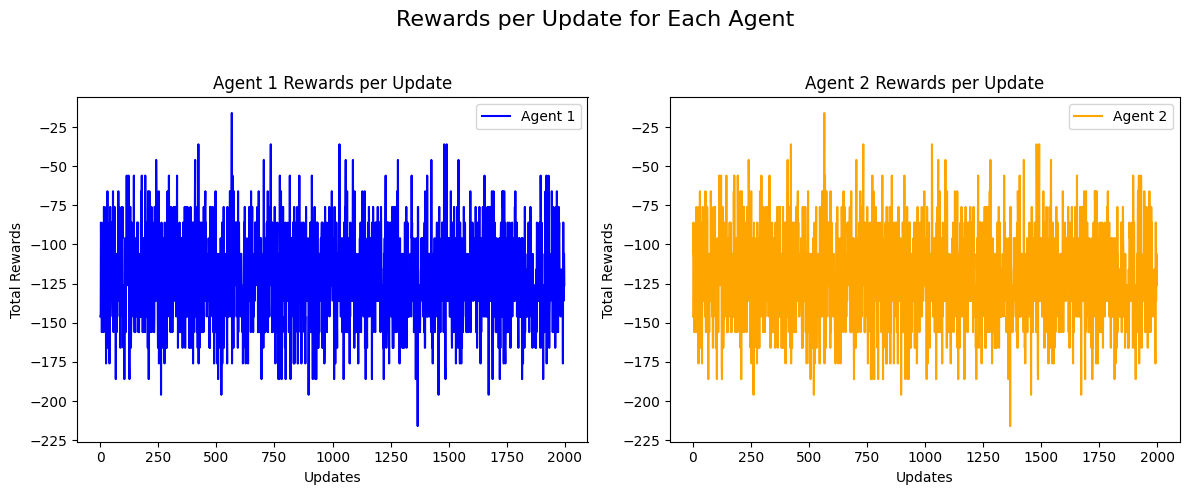

In [137]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_p1, rewards_p2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(rewards_p1, label="Agent 1", color='blue')
    axs[0].set_xlabel("Updates")
    axs[0].set_ylabel("Total Rewards")
    axs[0].set_title("Agent 1 Rewards per Update")
    axs[0].legend()

    axs[1].plot(rewards_p2, label="Agent 2", color='orange')
    axs[1].set_xlabel("Updates")
    axs[1].set_ylabel("Total Rewards")
    axs[1].set_title("Agent 2 Rewards per Update")
    axs[1].legend()

    fig.suptitle("Rewards per Update for Each Agent", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_rewards(rewards_p1, rewards_p2)

In [138]:
save_multiagent_models(model_p1, model_p2, 'ppo_lumberjacks_p1.pth', 'ppo_lumberjacks_p2.pth')



In [139]:
load_multiagent_models(model_p1, model_p2, 'ppo_lumberjacks_p1.pth', 'ppo_lumberjacks_p2.pth')
eval_rewards_p1, eval_rewards_p2 = evaluate_multiagent(env, model_p1, model_p2, num_episodes=10, render=False)

Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode
Grid configuration same as last episode


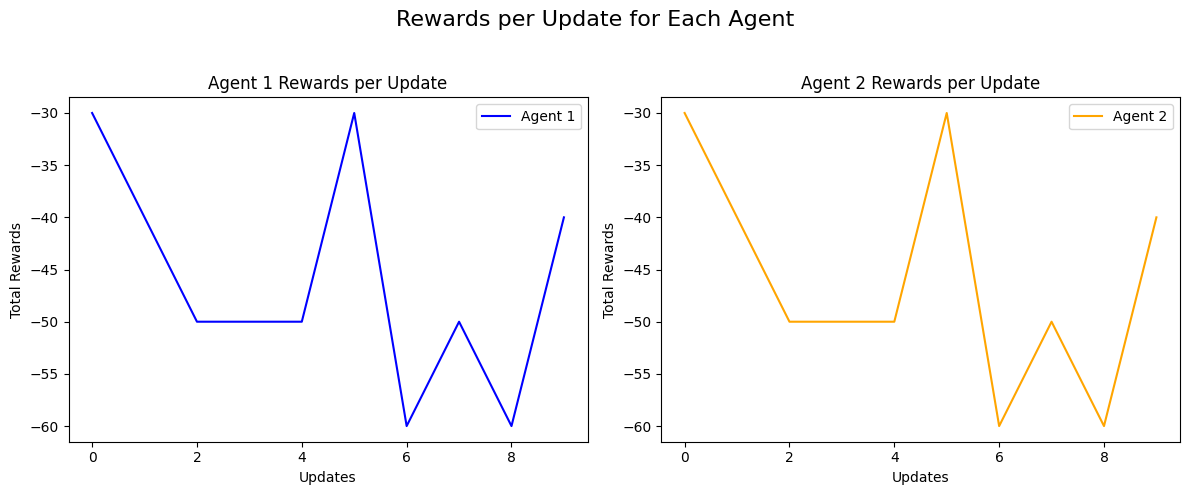

In [140]:
plot_rewards(eval_rewards_p1, eval_rewards_p2)

# References
1. https://github.com/koulanurag/ma-gym